In [15]:
import sys
sys.path.insert(0,'/home/heatphoenix/aihwkit_pr/aihwkit/src')
!export PYTHONPATH=$PYTHONPATH:./aihwkit/src/  

# Core imports
from mycore import ast2station_rotating, ast2station_rotating2

# PyTorch and ML
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Main imports
import heyoka as hy
import pykep as pk
import pandas as pd

# Usual imports
import time
import numpy as np
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

# Jupyter setup
%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setting up IBM AI HW Kit

In [16]:
# Imports from PyTorch.
from torch import nn
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import torch.nn.functional as F

import MultiplyLayer as custom_nn

# Imports from aihwkit.
from aihwkit.nn import AnalogConv1d, AnalogConv2d, AnalogLinear, AnalogSequential
from aihwkit.optim import AnalogSGD
from aihwkit.simulator.configs import SingleRPUConfig, ConstantStepDevice
from aihwkit.simulator.rpu_base import cuda
from aihwkit.simulator.parameters import WeightNoiseType
from aihwkit.simulator.configs import InferenceRPUConfig, WeightModifierType
from aihwkit.simulator.presets import ReRamESPreset
from aihwkit.simulator.presets.devices import ReRamArrayHfO2PresetDevice
from aihwkit.inference import ReRamWan2022NoiseModel, PCMLikeNoiseModel
from aihwkit.nn.conversion import convert_to_analog
from aihwkit.simulator.tiles.base import AnalogTileStateNames, BaseTile, TileModuleBase
from aihwkit.exceptions import TileModuleError

In [17]:
if torch.cuda.is_available():
    print("PyTorch detected CUDA")
    device = torch.device("cuda:0")
else: 
    print("PyTorch DID NOT detect CUDA")
    device = torch.device("cpu")
print("Training on :", device)

PyTorch detected CUDA
Training on : cuda:0


# Model definition

In [18]:

#from aihwkit_pr.aihwkit.src.aihwkit.nn.modules.linear_sliced import AnalogLinearBitSlicing
from aihwkit.nn import AnalogLinearBitSlicing

# A FFNN with continuous activation functions (softplus)
neurons = 128
model = AnalogSequential(
    AnalogLinearBitSlicing(6, neurons, slices, True, rpu_config=rpu_config),
    nn.Softplus(),
    AnalogLinearBitSlicing(neurons, neurons, slices, True, rpu_config=rpu_config),
    nn.Softplus(),
    AnalogLinearBitSlicing(neurons, neurons, slices, True, rpu_config=rpu_config),
    nn.Softplus(),
    AnalogLinearBitSlicing(neurons, 3, slices, True, rpu_config=rpu_config),
)
model = model.cuda(device)

ImportError: cannot import name 'AnalogLinearBitSlicing' from 'aihwkit.nn' (/home/heatphoenix/miniforge3/envs/aihwkit/lib/python3.11/site-packages/aihwkit/nn/__init__.py)

# Convert model to Analog

In [ ]:
model = convert_to_analog(model, rpu_config)
model = model.cuda(device)

In [ ]:
#n_epochs = 10, right now (originally 300)
#128 neurons
model.load_state_dict(torch.load("models/150_epochs_4_layers_128_neurons_0.0_fault_8_slices_16384_batch_size_rram_loss2_2024-05-22 17:17:18.mdl"))

<All keys matched successfully>

# Load trajectories
Ideally these will be not the ones we used for training (good practive) even if in this particular case and application there is not much difference

In [ ]:
with open("data/test_250_100_[0.001, 0.001, 0.001, 0.001]_[1.0, 1.0, 1.0, 1.0].pk", "rb") as file:
    data = pkl.load(file)

In [ ]:
traj_id = 34
# We load the data for one particular trajectory
state = torch.tensor(data[traj_id][:,:6], device=device)
labels = torch.tensor(data[traj_id][:,6:9], device=device)

In [ ]:
# We compute the thrust predicted by the model
predictions = model(state.float())
norms = torch.norm(predictions, dim=1)
predictions = predictions/norms.view(-1,1)

In [ ]:
def cart2angles(cart):
    theta = torch.acos(cart[:,2])
    phi = torch.atan2(cart[:,1], cart[:,0])
    return theta, phi

In [ ]:
theta, phi = cart2angles(predictions)
theta_labels, phi_labels = cart2angles(labels)
tf = 4.6194
tgrid = np.linspace(0, tf, 100)

torch.return_types.min(
values=tensor([-0.9778, -1.0000, -0.3639], device='cuda:0', grad_fn=<MinBackward0>),
indices=tensor([49,  2, 91], device='cuda:0'))
torch.Size([100, 3])
torch.return_types.max(
values=tensor([0.9855, 0.9858, 0.6518], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([29, 82, 72], device='cuda:0'))
tensor([ 4.1995e-02,  3.9163e-04,  3.7361e-04, -4.1365e-02,  3.6955e-04,
         3.5576e-04,  4.7797e-02,  4.2110e-04,  3.8917e-04,  2.9129e-04,
         3.2143e-04,  5.2998e-02,  3.6321e-04, -6.5616e-02,  1.1445e-01,
        -5.5467e-02, -1.0459e-01,  8.9063e-02,  4.2051e-04, -4.8162e-02,
        -1.1185e-01,  4.3123e-02,  4.4854e-04, -8.4163e-02, -5.1044e-02,
         4.9653e-02,  5.0395e-02, -2.2263e-01, -1.7687e-01, -1.5065e-01,
         9.8352e-02,  5.4920e-02, -1.9500e-01,  4.0518e-02, -4.4606e-02,
         4.7141e-02,  6.3929e-02,  1.6527e-01,  1.4550e-01,  3.3379e-04,
        -1.2914e-01,  5.0277e-04,  3.8998e-04,  1.9685e-01,  6.4546e-02,
         4.27

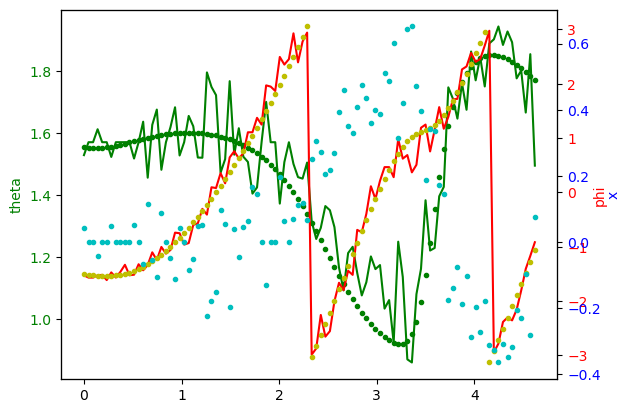

In [ ]:
from numpy import minimum


fig, ax1 = plt.subplots()

color = 'g'
ax1.plot(tgrid, theta.detach().cpu(), color)
ax1.plot(tgrid, theta_labels.detach().cpu(), 'g.', label = "theta")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('theta', color=color)

color = 'r'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(tgrid, phi.detach().cpu(), color)
ax2.plot(tgrid, phi_labels.detach().cpu(), 'y.', label = "phi")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('phi', color=color)

color = 'b'
ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#ax3.plot(tgrid, predictions[:,0].detach().cpu(), color)
ax3.plot(tgrid, predictions[:,2].detach().cpu(), 'c.', label = "phi")
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_ylabel('x', color=color)

print(predictions.min(dim=0))
print(predictions.shape)
print(predictions.max(dim=0))

print(predictions[:,2])

Text(0.5, 1.0, 'Example Trajectory id:(34)')

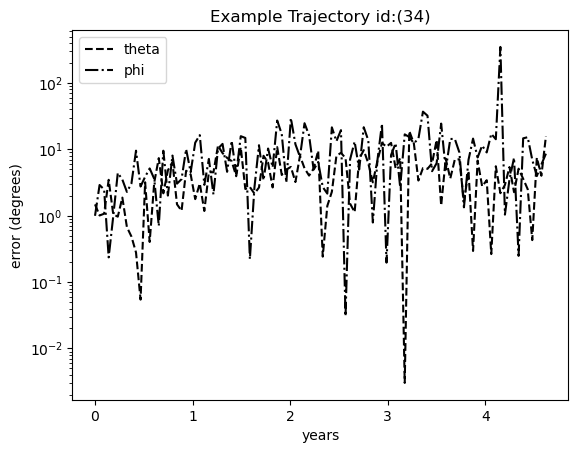

In [ ]:
plt.figure()
plt.semilogy(tgrid, np.abs(theta.detach().cpu() - theta_labels.detach().cpu()) / np.pi*180, "k--", label="theta")
plt.semilogy(tgrid, np.abs(phi.detach().cpu() - phi_labels.detach().cpu()) / np.pi*180, "k-.", label="phi")
plt.legend()
plt.xlabel("years")
plt.ylabel("error (degrees)")
plt.title(f"Example Trajectory id:({traj_id})")

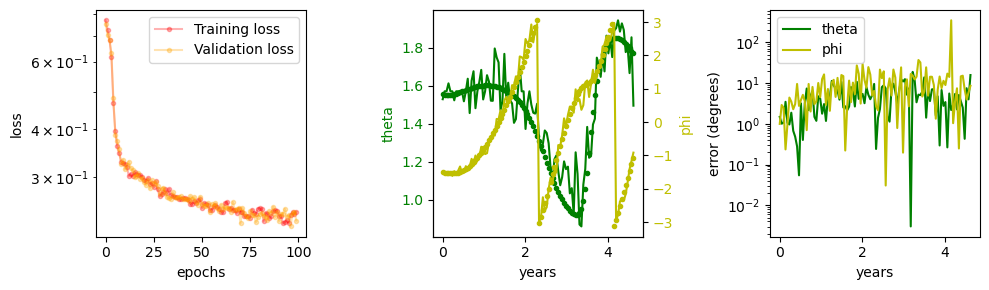

In [ ]:
with open("figures/loss_data.pk", "rb") as file:
    loss_list, loss_val_list = pkl.load(file)

fig, axes = plt.subplots(1,3, figsize=(10,3))
axes[0].semilogy(loss_list, 'red', marker='.',label='Training loss', alpha=0.3)
axes[0].semilogy(loss_val_list, 'orange', marker='.', label='Validation loss', alpha=0.3)
axes[0].legend()
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epochs')


color = 'g'
axes[1].plot(tgrid, theta.detach().cpu(), color)
axes[1].plot(tgrid, theta_labels.detach().cpu(), 'g.', label = "theta")
axes[1].tick_params(axis='y', labelcolor=color)
axes[1].set_ylabel('theta', color=color)
axes[1].set_xlabel('years')


color = 'y'
ax2 = axes[1].twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(tgrid, phi.detach().cpu(), color)
ax2.plot(tgrid, phi_labels.detach().cpu(), 'y.', label = "phi")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('phi', color=color)

axes[2].semilogy(tgrid, np.abs(theta.detach().cpu() - theta_labels.detach().cpu()) / np.pi*180, "g", label="theta")
axes[2].semilogy(tgrid, np.abs(phi.detach().cpu() - phi_labels.detach().cpu()) / np.pi*180, "y", label="phi")
axes[2].legend()
axes[2].set_xlabel("years")
axes[2].set_ylabel("error (degrees)")


plt.tight_layout()

In [ ]:
plt.savefig("figures/loss.png", dpi=600)

<Figure size 640x480 with 0 Axes>